In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import lstsq
from scipy.fft import fft
from scipy.io import loadmat
from PIL import Image
import os

# Display config
np.set_printoptions(suppress=True)
plt.rcParams['figure.dpi'] = 120

print("Notebook initialized.")

Notebook initialized.


In [2]:
def imread_rgb(path):
    img = Image.open(path).convert('RGB')
    return np.array(img)

def imsave_rgb(path, arr):
    arr8 = np.clip(arr, 0, 255).astype(np.uint8)
    Image.fromarray(arr8).save(path)

def show_image(img, title="", cmap=None, figsize=(6,4)):
    plt.figure(figsize=figsize)
    if img.ndim == 2:
        plt.imshow(img, cmap=cmap or 'gray')
    else:
        plt.imshow(np.clip(img, 0, 255).astype(np.uint8))
    plt.title(title)
    plt.axis('off')
    plt.show()

def rmse(a, b):
    # Crop to min common size
    H = min(a.shape[0], b.shape[0])
    W = min(a.shape[1], b.shape[1])
    if a.ndim == 3:
        C = min(a.shape[2], b.shape[2])
        a_ = a[:H,:W,:C].astype(np.float64)
        b_ = b[:H,:W,:C].astype(np.float64)
    else:
        a_ = a[:H,:W].astype(np.float64)
        b_ = b[:H,:W].astype(np.float64)
    return np.sqrt(np.mean((a_ - b_)**2))

In [3]:
FISH_PATH = "fish.png"
GAUSS_NOISE_MAT_PATH = "gaussNoise.mat"  # expects a var 'noise' or 'gaussian_noise' or (H,W[,C]) shaped
BACKGROUND_PATH = "background.png"
REDCAR_PATH = "redcar.png"
CAMERA_T_MAT_PATH = "CameraT.mat"       # expects a var like 'CameraT' or 'cameraT' or 'T' of length 52

# Common constants
EXPOSURE_TIME = 52  # seconds (t=0..51)

# -----------------------
# Load data
# -----------------------
img_clean = imread_rgb(FISH_PATH)
print("img_clean shape = ", img_clean.shape, type(img_clean))

# Load gaussian noise
mat = loadmat(GAUSS_NOISE_MAT_PATH)
gaussian_noise = mat['gaussNoise']

print("gaussian_noise shape = ", gaussian_noise.shape, type(gaussian_noise))

# Ensure the width matches N + 51
H, W = img_clean.shape[:2]
if gaussian_noise.shape[1] != W + (EXPOSURE_TIME-1):
    raise ValueError("gaussian_noise width does not match N + 51. Please adjust or reshape noise file.")

background_img = imread_rgb(BACKGROUND_PATH)
redcar_img = imread_rgb(REDCAR_PATH)


print("Data prepared.")


img_clean shape =  (450, 800, 3) <class 'numpy.ndarray'>
gaussian_noise shape =  (450, 851, 3) <class 'numpy.ndarray'>
Data prepared.


In [4]:
# -----------------------
# Image blur synthesizers (horizontal motion)
# -----------------------

def apply_horizontal_motion_blur(img, exposure_time=EXPOSURE_TIME, weights=None):
    """
    Convolves each row horizontally with a box/weighted kernel by stacking shifted copies.
    Returns blurred image of shape (H, W + exposure_time - 1, C).
    """
    H, W = img.shape[:2]
    C = img.shape[2]
    if weights is None:
        weights = np.ones(exposure_time, dtype=np.float64) / exposure_time
    else:
        weights = np.array(weights, dtype=np.float64)
        weights = weights / (weights.sum() + 1e-12)

    out_W = W + exposure_time - 1
    out = np.zeros((H, out_W, C), dtype=np.float64)

    imgf = img.astype(np.float64)

    for t, w in enumerate(weights):
        if w == 0: 
            continue
        # place img at columns [t:t+W]
        out[:, t:t+W, :] += w * imgf

    return out

def deblur_rowwise_least_squares(blurred, A):
    """
    Solve xA = b for each row (and channel). 
    blurred: (H, Wb, C) with Wb = A.shape[0]
    A: (Wb, W)
    Returns deblurred image (H, W, C).
    """
    H = blurred.shape[0]
    W = A.shape[1]
    C = blurred.shape[2]
    out = np.zeros((H, W, C), dtype=np.float64)

    for c in range(C):
        for r in range(H):
            b = blurred[r, :, c]
            # Ensure length matches A rows
            x, *_ = lstsq(A, b)
            out[r, :, c] = x
    return out

In [5]:
# -----------------------
# Blur matrix constructors
# -----------------------

def blur_matrix_uniform(N, exposure_time=EXPOSURE_TIME):
    # Toeplitz-like matrix A: (N+T-1) x N with 1/T along the banded diagonals
    out_rows = N + exposure_time - 1
    A = np.zeros((out_rows, N), dtype=np.float64)
    w = 1.0 / exposure_time
    for j in range(N):
        r0 = j
        r1 = min(j + exposure_time, out_rows)
        A[r0:r1, j] = w
    return A

def blur_matrix_weighted(N, weights):
    # weights length = exposure_time; normalized externally
    exposure_time = len(weights)
    out_rows = N + exposure_time - 1
    A = np.zeros((out_rows, N), dtype=np.float64)
    for j in range(N):
        for t in range(exposure_time):
            r = j + t
            if r < out_rows:
                A[r, j] = weights[t]
    return A

Problem 2: Motion deblurring (flutter shutter)
(a)(b) Flutter blurred images and matrices prepared.


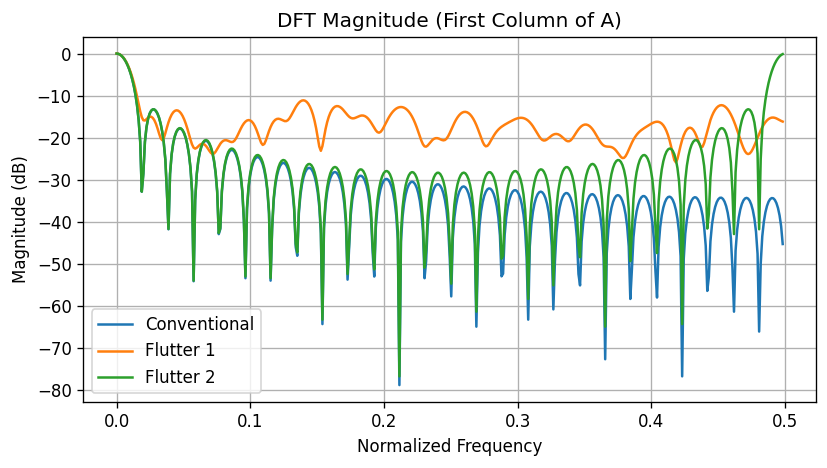

(c) Comment: Flutter codes distribute energy more uniformly across frequencies than a box blur, improving invertibility for LS deblurring.
(e) RMSEs (noisy): Flutter1=8.7405, Flutter2=62.2713
    The difference arises from distinct frequency responses of the codes and their invertibility characteristics.
(f) No-noise RMSEs: Conventional=0.0000, Flutter1=0.0000, Flutter2=0.0000


In [6]:
# ==============================================
# Problem 2: Motion deblurring with flutter shutter
# ==============================================
print("Problem 2: Motion deblurring (flutter shutter)")

H, W = img_clean.shape[:2]
A_conv = blur_matrix_uniform(W, EXPOSURE_TIME)

code1 = "1010000111000001010000110011110111010111001001100111"
code2 = "1010101010101010101010101010101010101010101010101010"
flutter1 = np.array([int(x) for x in code1], dtype=np.float64)
flutter2 = np.array([int(x) for x in code2], dtype=np.float64)

w1 = flutter1 / (flutter1.sum() + 1e-12)
w2 = flutter2 / (flutter2.sum() + 1e-12)

# (a) Generate blurred images with noise
blurred_f1 = apply_horizontal_motion_blur(img_clean, exposure_time=len(flutter1), weights=w1)
blurred_f2 = apply_horizontal_motion_blur(img_clean, exposure_time=len(flutter2), weights=w2)

blurred_f1_noisy = blurred_f1 + gaussian_noise
blurred_f2_noisy = blurred_f2 + gaussian_noise

# (b) Form blur matrices
A_f1 = blur_matrix_weighted(W, w1)
A_f2 = blur_matrix_weighted(W, w2)

print("(a)(b) Flutter blurred images and matrices prepared.")

# (c) DFTs of the first column of A matrices; plot magnitude in dB and comment
def mag_db(x):
    return 20*np.log10(np.maximum(np.abs(x), 1e-12))

conv_kernel = A_conv[:,0]
f1_kernel = A_f1[:,0]
f2_kernel = A_f2[:,0]

F_conv = mag_db(fft(conv_kernel))
F_f1   = mag_db(fft(f1_kernel))
F_f2   = mag_db(fft(f2_kernel))

freq = np.arange(len(F_conv)) / len(F_conv)

plt.figure(figsize=(7,4))
plt.plot(freq[:len(freq)//2], F_conv[:len(freq)//2], label='Conventional')
plt.plot(freq[:len(freq)//2], F_f1[:len(freq)//2], label='Flutter 1')
plt.plot(freq[:len(freq)//2], F_f2[:len(freq)//2], label='Flutter 2')
plt.xlabel("Normalized Frequency")
plt.ylabel("Magnitude (dB)")
plt.title("DFT Magnitude (First Column of A)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("(c) Comment: Flutter codes distribute energy more uniformly across frequencies than a box blur, improving invertibility for LS deblurring.")

# (d) Deblur using LS
rec_f1 = deblur_rowwise_least_squares(blurred_f1_noisy, A_f1)
rec_f2 = deblur_rowwise_least_squares(blurred_f2_noisy, A_f2)

# (e) RMSEs vs original
rmse_f1 = rmse(img_clean, rec_f1)
rmse_f2 = rmse(img_clean, rec_f2)
print(f"(e) RMSEs (noisy): Flutter1={rmse_f1:.4f}, Flutter2={rmse_f2:.4f}")
print("    The difference arises from distinct frequency responses of the codes and their invertibility characteristics.")

# (f) No-noise comparison
blurred_conv_clean = apply_horizontal_motion_blur(img_clean, EXPOSURE_TIME)
blurred_f1_clean   = apply_horizontal_motion_blur(img_clean, exposure_time=len(flutter1), weights=w1)
blurred_f2_clean   = apply_horizontal_motion_blur(img_clean, exposure_time=len(flutter2), weights=w2)

rec_conv_clean = deblur_rowwise_least_squares(blurred_conv_clean, A_conv)
rec_f1_clean   = deblur_rowwise_least_squares(blurred_f1_clean, A_f1)
rec_f2_clean   = deblur_rowwise_least_squares(blurred_f2_clean, A_f2)

rmse_conv_nn = rmse(img_clean, rec_conv_clean)
rmse_f1_nn   = rmse(img_clean, rec_f1_clean)
rmse_f2_nn   = rmse(img_clean, rec_f2_clean)

print(f"(f) No-noise RMSEs: Conventional={rmse_conv_nn:.4f}, Flutter1={rmse_f1_nn:.4f}, Flutter2={rmse_f2_nn:.4f}")

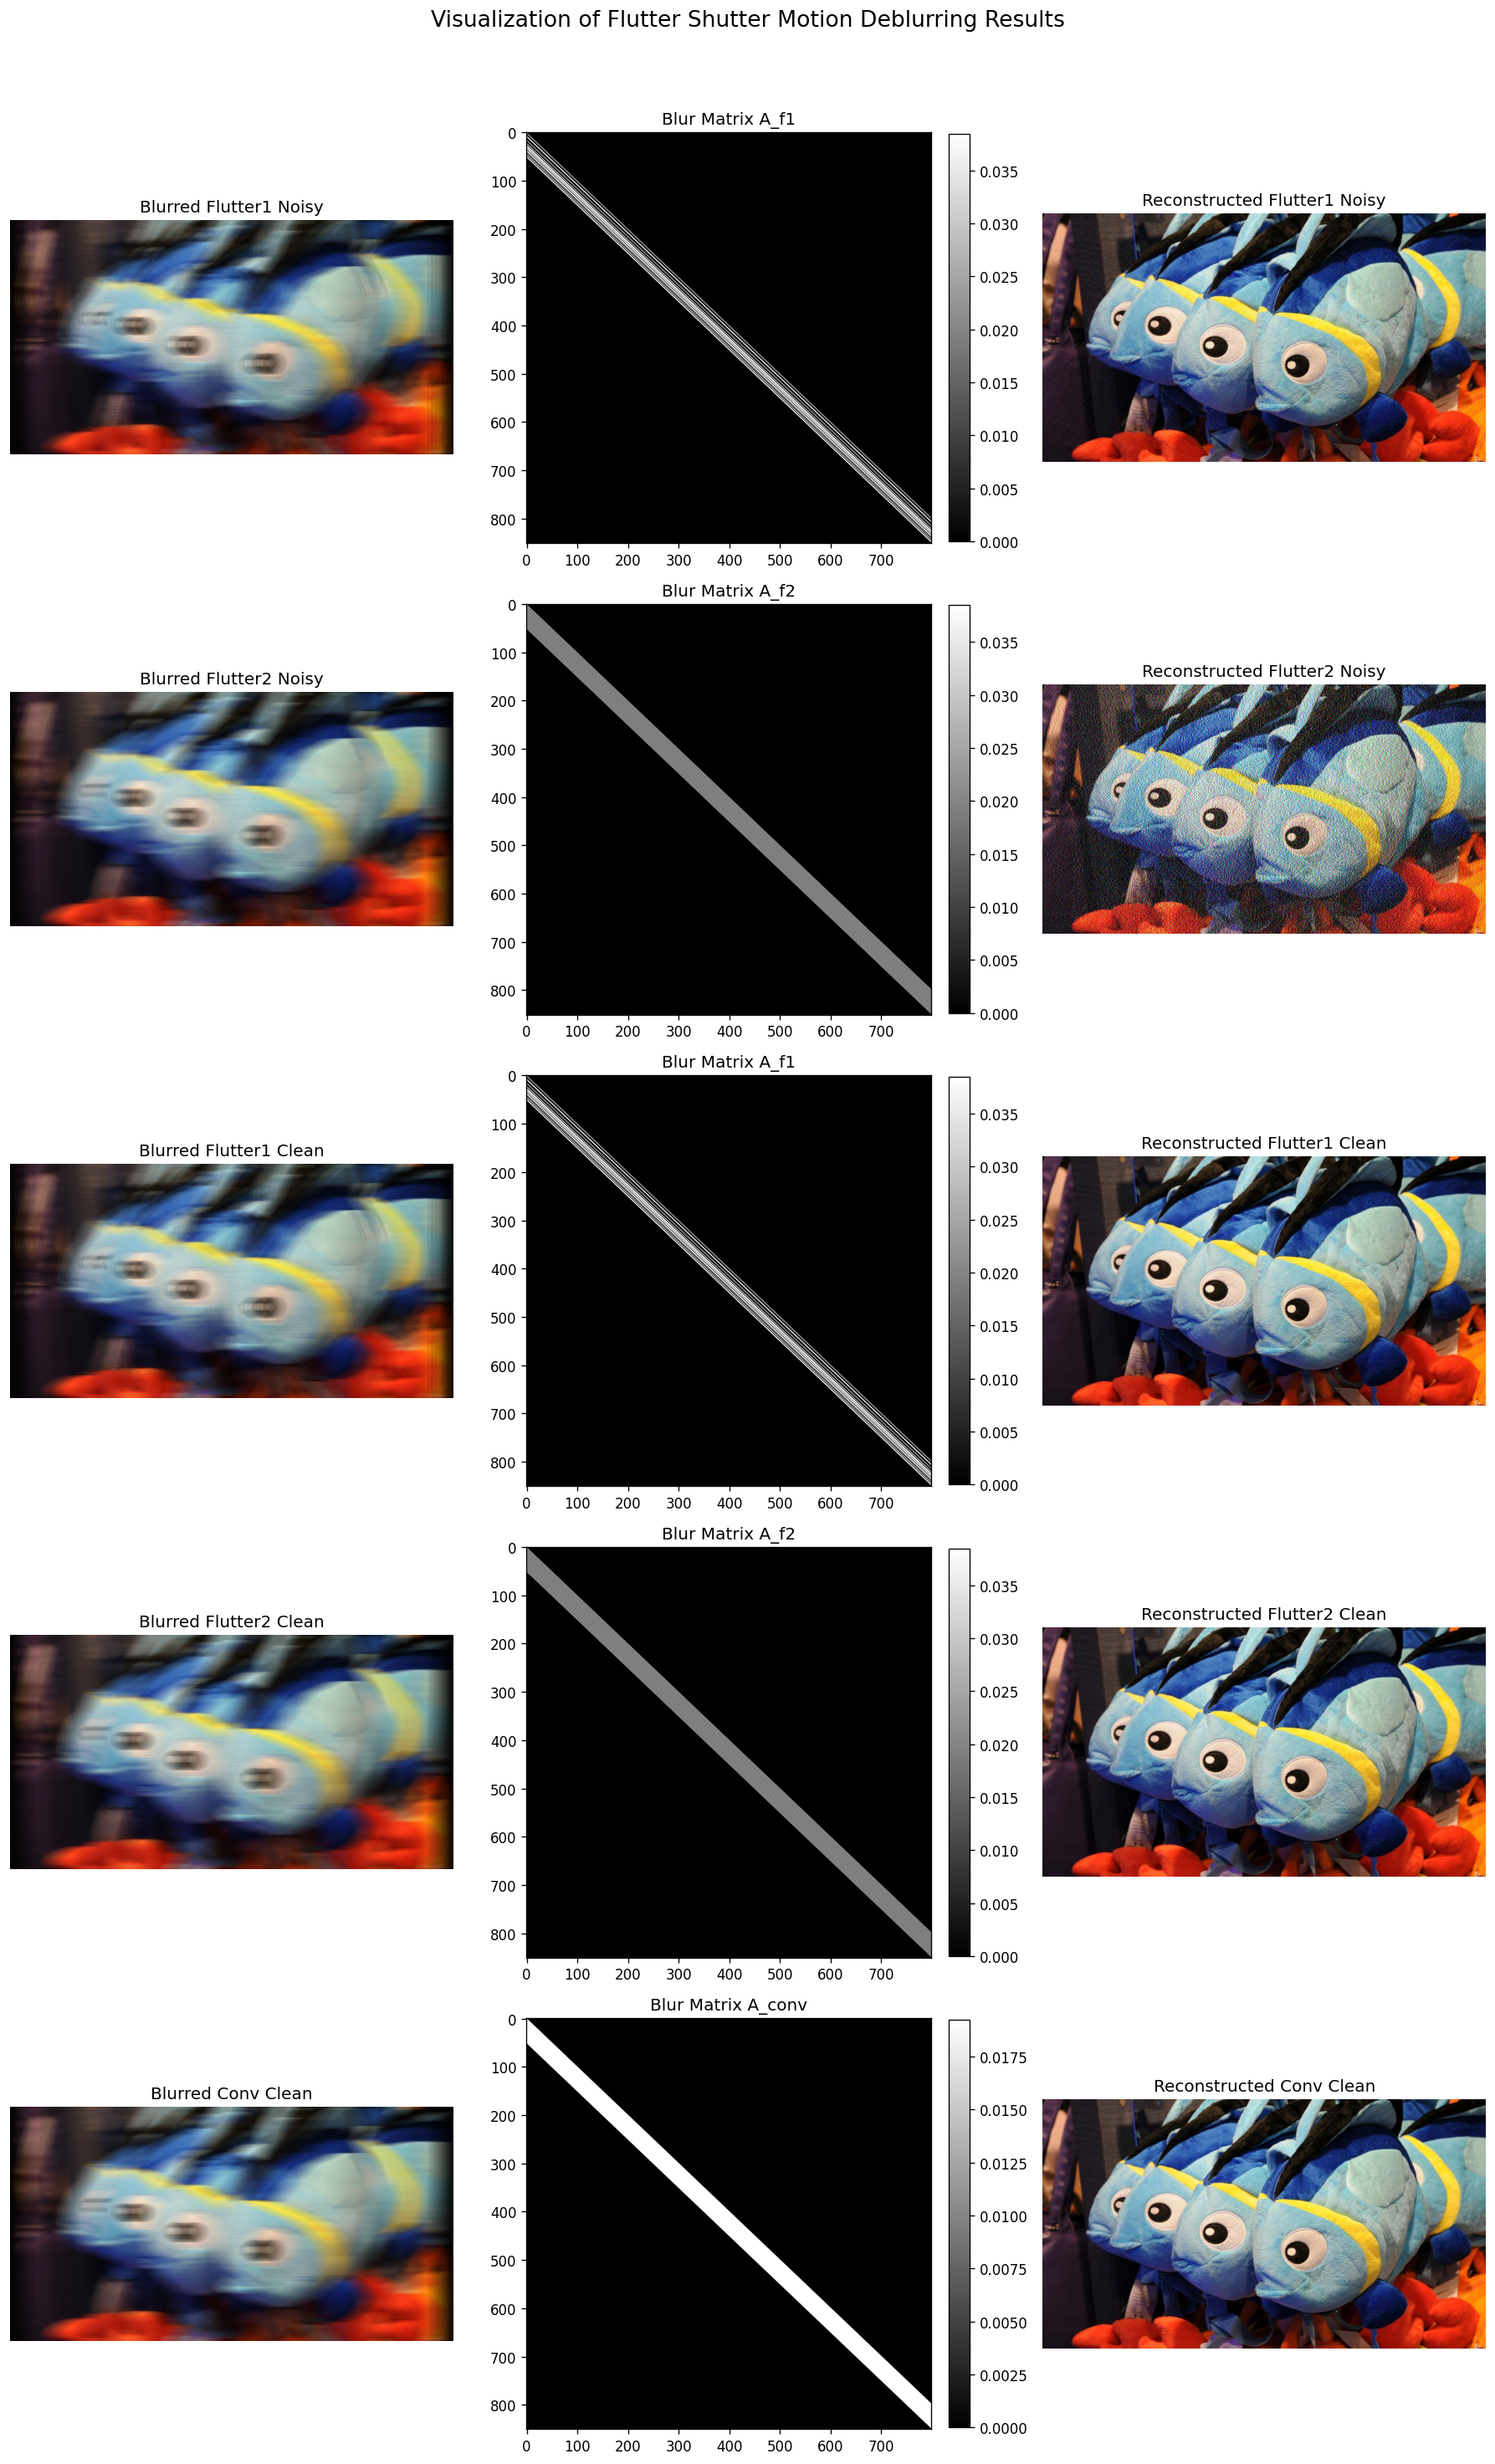

    Without noise, LS inversion closely recovers the original for all, with flutter benefits more apparent under noise.


In [7]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(5, 3, figsize=(15, 25))
fig.suptitle("Visualization of Flutter Shutter Motion Deblurring Results", fontsize=16)

# Row 1: Flutter1 Noisy
axes[0, 0].imshow(np.clip(blurred_f1_noisy, 0, 255).astype(np.uint8), cmap='gray')
axes[0, 0].set_title('Blurred Flutter1 Noisy')
axes[0, 0].axis('off')

im_A_f1_0 = axes[0, 1].imshow(A_f1, aspect='auto', cmap='gray')
axes[0, 1].set_title('Blur Matrix A_f1')
plt.colorbar(im_A_f1_0, ax=axes[0, 1], fraction=0.046, pad=0.04)

axes[0, 2].imshow(np.clip(rec_f1, 0, 255).astype(np.uint8))
axes[0, 2].set_title('Reconstructed Flutter1 Noisy')
axes[0, 2].axis('off')

# Row 2: Flutter2 Noisy
axes[1, 0].imshow(np.clip(blurred_f2_noisy, 0, 255).astype(np.uint8), cmap='gray')
axes[1, 0].set_title('Blurred Flutter2 Noisy')
axes[1, 0].axis('off')

im_A_f2_1 = axes[1, 1].imshow(A_f2, aspect='auto', cmap='gray')
axes[1, 1].set_title('Blur Matrix A_f2')
plt.colorbar(im_A_f2_1, ax=axes[1, 1], fraction=0.046, pad=0.04)

axes[1, 2].imshow(np.clip(rec_f2, 0, 255).astype(np.uint8))
axes[1, 2].set_title('Reconstructed Flutter2 Noisy')
axes[1, 2].axis('off')

# Row 3: Flutter1 Clean
axes[2, 0].imshow(np.clip(blurred_f1_clean, 0, 255).astype(np.uint8))
axes[2, 0].set_title('Blurred Flutter1 Clean')
axes[2, 0].axis('off')

im_A_f1_2 = axes[2, 1].imshow(A_f1, aspect='auto', cmap='gray')
axes[2, 1].set_title('Blur Matrix A_f1')
plt.colorbar(im_A_f1_2, ax=axes[2, 1], fraction=0.046, pad=0.04)

axes[2, 2].imshow(np.clip(rec_f1_clean, 0, 255).astype(np.uint8))
axes[2, 2].set_title('Reconstructed Flutter1 Clean')
axes[2, 2].axis('off')

# Row 4: Flutter2 Clean
axes[3, 0].imshow(np.clip(blurred_f2_clean, 0, 255).astype(np.uint8))
axes[3, 0].set_title('Blurred Flutter2 Clean')
axes[3, 0].axis('off')

im_A_f2_3 = axes[3, 1].imshow(A_f2, aspect='auto', cmap='gray')
axes[3, 1].set_title('Blur Matrix A_f2')
plt.colorbar(im_A_f2_3, ax=axes[3, 1], fraction=0.046, pad=0.04)

axes[3, 2].imshow(np.clip(rec_f2_clean, 0, 255).astype(np.uint8))
axes[3, 2].set_title('Reconstructed Flutter2 Clean')
axes[3, 2].axis('off')

# Row 5: Conventional Blur Clean + Noisy + Recon
axes[4, 0].imshow(np.clip(blurred_conv_clean, 0, 255).astype(np.uint8), cmap='gray')
axes[4, 0].set_title('Blurred Conv Clean')
axes[4, 0].axis('off')

im_A_conv = axes[4, 1].imshow(A_conv, cmap='gray', aspect='auto')
axes[4, 1].set_title('Blur Matrix A_conv')
plt.colorbar(im_A_conv, ax=axes[4, 1], fraction=0.046, pad=0.04)

axes[4, 2].imshow(np.clip(rec_conv_clean, 0, 255).astype(np.uint8))
axes[4, 2].set_title('Reconstructed Conv Clean')
axes[4, 2].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

print("    Without noise, LS inversion closely recovers the original for all, with flutter benefits more apparent under noise.")